In [1]:
import os
from pathlib import Path

import numpy as np
import torch
from torch_geometric.datasets import TUDataset


c:\Users\default.LAPTOP-D71TUC29\anaconda3\Lib\site-packages\torch\__config__.py:9: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10\cuda\CUDAFunctions.cpp:119.)
  return torch._C._show_config()


In [2]:
def load_mutag_dataset(root_dir="data"):
    """
    WHAT:
      Load the MUTAG dataset as a PyG TUDataset.

    HOW:
      - TUDataset will download & preprocess MUTAG into PyG's Data objects.
      - Each item is a small molecule graph with:
          * data.x        : node features (7-dim one-hot atom type)
          * data.edge_index: edges (2 x num_edges)
          * data.edge_attr : edge features (4-dim one-hot bond type)
          * data.y        : graph label (0/1)

    WHY:
      We need this representation so we can:
        1) convert each graph to gSpan's text format
        2) later align gSpan’s patterns back to graph indices.
    """
    dataset = TUDataset(root=root_dir, name="MUTAG")
    print(f"Loaded MUTAG with {len(dataset)} graphs")
    print(f"Node feature dim:  {dataset.num_features}")
    print(f"Edge feature dim:  {dataset.num_edge_features}")
    print(f"Number of classes: {dataset.num_classes}")
    return dataset


In [4]:
def infer_node_label_vector(x_row):
    """
    WHAT:
      Convert a node's feature vector into a single discrete label.

    HOW:
      - In MUTAG, each node feature row is one-hot over 7 atom types.
      - argmax gives an integer in [0, 6] representing the atom type.

    WHY:
      gSpan only accepts one integer label per node.
    """
    if x_row is None:
        # Fallback if no node features exist (not the case for MUTAG)
        return 0
    return int(torch.argmax(x_row).item())


def infer_edge_label_vector(edge_attr_row):
    """
    WHAT:
      Convert an edge feature vector into a single discrete label.

    HOW:
      - In MUTAG, each edge feature row is one-hot over bond types.
      - argmax gives an integer in [0, 3] representing the bond type.

    WHY:
      gSpan expects a single integer label per edge.
    """
    if edge_attr_row is None:
        return 0
    return int(torch.argmax(edge_attr_row).item())


In [5]:
def write_graphs_to_gspan_file(dataset, out_path):
    """
    WHAT:
      Write all graphs in the dataset into a single text file in gSpan format.

    FORMAT (per graph):
        t # <graph_id>
        v <node_id> <node_label>
        e <u> <v> <edge_label>

    HOW:
      - Iterate over all graphs (molecules) in MUTAG.
      - For each:
          * write 't # i'
          * write one 'v' line per node
          * deduplicate edges and write one 'e' line per undirected edge

    WHY:
      gSpan takes a "graph database" text file as input, not a Python object.
    """
    out_path = Path(out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)

    with out_path.open("w") as f:
        for graph_id, data in enumerate(dataset):
            # Start a new graph block in the file
            f.write(f"t # {graph_id}\n")

            # ---------- Node lines ('v') ----------
            num_nodes = data.num_nodes
            x = getattr(data, "x", None)

            for node_id in range(num_nodes):
                if x is not None:
                    node_label = infer_node_label_vector(x[node_id])
                else:
                    node_label = 0  # fallback if no features
                f.write(f"v {node_id} {node_label}\n")

            # ---------- Edge lines ('e') ----------
            edge_index = data.edge_index      # shape [2, num_edges]
            edge_attr  = getattr(data, "edge_attr", None)

            # Use a set to deduplicate undirected edges
            undirected_edges = set()

            num_edges = edge_index.size(1)
            for e_idx in range(num_edges):
                u = int(edge_index[0, e_idx])
                v = int(edge_index[1, e_idx])

                # Skip self-loops if any
                if u == v:
                    continue

                # Enforce u < v for undirected representation
                a, b = sorted((u, v))

                if edge_attr is not None:
                    edge_label = infer_edge_label_vector(edge_attr[e_idx])
                else:
                    edge_label = 0

                undirected_edges.add((a, b, edge_label))

            # Actually write the edge lines
            for a, b, edge_label in sorted(undirected_edges):
                f.write(f"e {a} {b} {edge_label}\n")

    print(f"Wrote gSpan database file to: {out_path.resolve()}")


In [6]:
dataset = load_mutag_dataset(root_dir="data")
write_graphs_to_gspan_file(dataset, "mutag_gspan.txt")


Loaded MUTAG with 188 graphs
Node feature dim:  7
Edge feature dim:  4
Number of classes: 2
Wrote gSpan database file to: C:\Users\default.LAPTOP-D71TUC29\Documents\School\CS 6010 - Data Science Programming\Project 3\mutag_gspan.txt


In [7]:
import sys
print(sys.executable)
!{sys.executable} -m pip show gspan-mining
!{sys.executable} -m gspan_mining -h


c:\Users\default.LAPTOP-D71TUC29\anaconda3\python.exe
Name: gspan-mining
Version: 0.2.3
Summary: Implementation of frequent subgraph mining algorithm gSpan
Home-page: https://github.com/betterenvi/gSpan
Author: Qingying Chen
Author-email: qychen.pku@gmail.com
License: UNKNOWN
Location: c:\Users\default.LAPTOP-D71TUC29\anaconda3\Lib\site-packages
Requires: 
Required-by: 
usage: __main__.py [-h] [-s MIN_SUPPORT] [-n NUM_GRAPHS]
                   [-l LOWER_BOUND_OF_NUM_VERTICES]
                   [-u UPPER_BOUND_OF_NUM_VERTICES] [-d DIRECTED] [-v VERBOSE]
                   [-p PLOT] [-w WHERE]
                   database_file_name

positional arguments:
  database_file_name    str, database file name

options:
  -h, --help            show this help message and exit
  -s MIN_SUPPORT, --min_support MIN_SUPPORT
                        min support, default 5000
  -n NUM_GRAPHS, --num_graphs NUM_GRAPHS
                        only read the first n graphs in the given database,
             

In [8]:
import subprocess
import sys
from pathlib import Path

def run_gspan(
    input_file="mutag_gspan.txt",
    output_file="mutag_gspan_out.txt",
    min_support=20,
    max_graphs=1000000,
    undirected=True,
):
    """
    Run gSpan on the given input file and save the output to output_file.

    - Always writes stdout to output_file (even if gSpan exits with a non-zero code).
    - Prints the first ~100 lines of gSpan's stdout/stderr for inspection.
    - Warns if gSpan exits with a non-zero return code, but does NOT raise.

    This keeps the pipeline moving so we can still parse patterns from the log.
    """
    input_path = Path(input_file).resolve()
    if not input_path.exists():
        raise FileNotFoundError(f"Input file not found: {input_path}")

    out_path = Path(output_file).resolve()
    out_path.parent.mkdir(parents=True, exist_ok=True)

    # Build the command: note the -w True so we get 'where:' lines in the output
    cmd = [
        sys.executable,
        "-m", "gspan_mining",
        "-s", str(min_support),
        "-n", str(max_graphs),
        "-d", "False" if undirected else "True",  # False = treat as UNDIRECTED
        "-w", "True",                             # IMPORTANT: output 'where' information
        str(input_path)
    ]

    print("Running command:")
    print("  " + " ".join(cmd))

    # Capture stdout and stderr together
    result = subprocess.run(
        cmd,
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        text=True
    )

    # Always dump gSpan output to the requested file
    with out_path.open("w", encoding="utf-8") as f_out:
        f_out.write(result.stdout)

    # Show the first 100 lines in the notebook for debugging
    print("\n=== gSpan stdout/stderr (first 100 lines) ===")
    lines = result.stdout.splitlines()
    for line in lines[:100]:
        print(line)
    if len(lines) > 100:
        print("... (truncated) ...")

    # If returncode != 0, just warn but DO NOT raise
    if result.returncode != 0:
        print(f"\n[WARNING] gSpan exited with code {result.returncode}.")
        print("         Check the log above or in the output file if something looks off.")
    else:
        print("\n gSpan finished successfully.")

    print(f"Output written to: {out_path}")


In [9]:
from pathlib import Path
import numpy as np

def parse_gspan_where_output_to_matrix(output_file, num_graphs):
    output_file = Path(output_file)

    if not output_file.exists():
        # This catches “file not created” issues *right here*
        raise FileNotFoundError(f"gSpan output file not found: {output_file.resolve()}")

    pattern_graph_ids = []
    current_pattern_idx = -1

    with output_file.open("r", encoding="utf-8") as f:
        for raw_line in f:
            line = raw_line.strip()
            if not line:
                continue

            if line.startswith("t "):
                current_pattern_idx += 1
                pattern_graph_ids.append([])

            elif line.startswith("where:"):
                if current_pattern_idx < 0:
                    continue
                part = line.split("where:", 1)[1].strip()
                part = part.strip("[]")
                gids = []
                if part:
                    for token in part.split(","):
                        token = token.strip()
                        if not token:
                            continue
                        gid = int(token)
                        gids.append(gid)
                pattern_graph_ids[current_pattern_idx] = gids

    num_patterns = len(pattern_graph_ids)
    print(f"Parsed {num_patterns} patterns from {output_file}")

    X = np.zeros((num_graphs, num_patterns), dtype=np.float32)
    for p_idx, gids in enumerate(pattern_graph_ids):
        for gid in gids:
            if gid < num_graphs:
                X[gid, p_idx] = 1.0

    return X

In [10]:
import numpy as np
import pandas as pd
from torch_geometric.datasets import TUDataset

# 1) Load MUTAG to get labels
dataset = TUDataset(root="data", name="MUTAG")
num_graphs = len(dataset)
print("Num graphs in MUTAG:", num_graphs)

# 2) Path to your gSpan output (the text file you already have)
GSPAN_OUTPUT_FILE = r"C:\Users\default.LAPTOP-D71TUC29\Documents\School\CS 6010 - Data Science Programming\Project 3\mutag_gspan_out.txt"

# 3) Parse gSpan output into feature matrix X
X = parse_gspan_where_output_to_matrix(GSPAN_OUTPUT_FILE, num_graphs)

# 4) Build label vector y from MUTAG
y = np.array([int(data.y.item()) for data in dataset], dtype=np.int64)

# 5) Build a DataFrame: graph_id, label, and feature columns
feature_names = [f"pattern_{j}" for j in range(X.shape[1])]

df = pd.DataFrame(X, columns=feature_names)
df.insert(0, "graph_id", np.arange(num_graphs))
df.insert(1, "label", y)

print("Feature DataFrame shape:", df.shape)
print(df.head())

# 6) Save to CSV in your project folder
FEATURE_CSV = r"C:\Users\default.LAPTOP-D71TUC29\Documents\School\CS 6010 - Data Science Programming\Project 3\mutag_features_support20.csv"
df.to_csv(FEATURE_CSV, index=False)
print("Saved feature CSV to:", FEATURE_CSV)


Num graphs in MUTAG: 188
Parsed 39492 patterns from C:\Users\default.LAPTOP-D71TUC29\Documents\School\CS 6010 - Data Science Programming\Project 3\mutag_gspan_out.txt
Feature DataFrame shape: (188, 39494)
   graph_id  label  pattern_0  pattern_1  pattern_2  pattern_3  pattern_4  \
0         0      1        1.0        1.0        1.0        1.0        1.0   
1         1      0        1.0        1.0        1.0        1.0        1.0   
2         2      0        1.0        1.0        1.0        1.0        1.0   
3         3      1        1.0        1.0        1.0        1.0        1.0   
4         4      0        1.0        1.0        1.0        1.0        1.0   

   pattern_5  pattern_6  pattern_7  ...  pattern_39482  pattern_39483  \
0        1.0        1.0        1.0  ...            1.0            1.0   
1        1.0        1.0        1.0  ...            1.0            1.0   
2        1.0        1.0        1.0  ...            1.0            1.0   
3        1.0        1.0        1.0  ... 

In [11]:
FEATURE_FILE = r"C:\Users\default.LAPTOP-D71TUC29\Documents\School\CS 6010 - Data Science Programming\Project 3\mutag_features_support20.csv"

GRAPH_ID_COL = "graph_id"
LABEL_COL    = "label"

df = pd.read_csv(FEATURE_FILE)


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from torch_geometric.datasets import TUDataset

# 1) Load MUTAG to get labels
dataset = TUDataset(root="data", name="MUTAG")
num_graphs = len(dataset)
y = np.array([int(data.y.item()) for data in dataset], dtype=np.int64)

# 2) Supports you want to test
supports_to_generate = [25, 30, 35, 40, 45, 50]

# 3) Base directory where you want all outputs
BASE_DIR = r"C:\Users\default.LAPTOP-D71TUC29\Documents\School\CS 6010 - Data Science Programming\Project 3"

for s in supports_to_generate:
    print(f"\n=== Generating features for min_support = {s} ===")

    # (a) Output path for this run
    gspan_out_file = Path(BASE_DIR) / f"mutag_gspan_out_support{s}.txt"

    # (b) Run gSpan; this will always write to gspan_out_file now
    run_gspan(
        input_file="mutag_gspan.txt",     # adjust if you moved this file
        output_file=str(gspan_out_file),
        min_support=s,
        max_graphs=1000000,
        undirected=True,
    )

    # Quick sanity check: the file should now exist
    print("Exists after run?:", gspan_out_file.exists())

    # (c) Parse gSpan output into X
    X_s = parse_gspan_where_output_to_matrix(gspan_out_file, num_graphs)

    # (d) Build DataFrame and save CSV
    feature_names = [f"pattern_{j}" for j in range(X_s.shape[1])]
    df_s = pd.DataFrame(X_s, columns=feature_names)
    df_s.insert(0, "graph_id", np.arange(num_graphs))
    df_s.insert(1, "label", y)

    feature_csv = Path(BASE_DIR) / f"mutag_features_support{s}.csv"
    df_s.to_csv(feature_csv, index=False)
    print(f"Saved CSV for support={s} to: {feature_csv}")




=== Generating features for min_support = 25 ===
Running command:
  c:\Users\default.LAPTOP-D71TUC29\anaconda3\python.exe -m gspan_mining -s 25 -n 1000000 -d False -w True C:\Users\default.LAPTOP-D71TUC29\Documents\School\CS 6010 - Data Science Programming\Project 3\mutag_gspan.txt


: 

: 

In [7]:
"""
Classical ML on MUTAG with frequent subgraph features
=====================================================

WHAT:  Train and evaluate an SVM and a Random Forest classifier
       on MUTAG graphs represented by frequent-subgraph features
       (mined using gSpan or a similar algorithm).

HOW:   1) Load a CSV where each row = a graph and columns = subgraph counts
       2) Split into train/test
       3) Build scikit-learn Pipelines for:
            - SVM (with scaling + hyperparameter tuning)
            - Random Forest (with hyperparameter tuning)
       4) Evaluate with multiple metrics
       5) Inspect feature importances / coefficients

WHY:   This is exactly the "classic ML" part of Q-1 in your project:
       you’re using mined subgraphs as features and training
       two classic ML models on top of them.
"""

# ==============================
# 0) Imports
# ==============================

import time  # for measuring runtime (efficiency trade-offs)
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)


# ==============================
# 1) Configuration
# ==============================

# WHAT: Path to your feature CSV created after running gSpan + feature construction.
# HOW:  Replace this with the REAL path to your file.
FEATURE_FILE = r"C:\Users\default.LAPTOP-D71TUC29\Documents\School\CS 6010 - Data Science Programming\Project 3\mutag_features_support20.csv"

# WHAT: Name of the columns that identify graph and label in your CSV.
# WHY:  We will drop ID and use all remaining numeric columns as features.
GRAPH_ID_COL = "graph_id"   # change if your column has a different name
LABEL_COL    = "label"      # change if your label column has a different name

# WHAT: Random seed for reproducibility
RANDOM_STATE = 42

# WHAT: Proportion of data used for testing
TEST_SIZE = 0.2  # 20% test, 80% train (you can tweak this)


# ==============================
# 2) Load data and build X, y
# ==============================

def load_feature_matrix(
    feature_file: str,
    label_col: str = LABEL_COL,
    id_col: str = GRAPH_ID_COL
):
    """
    WHAT:
        Load the subgraph-based feature matrix and labels from a CSV.

    HOW:
        - Reads a CSV with pandas.
        - Extracts:
            X: all numeric columns except (id_col, label_col)
            y: the label column

    WHY:
        Classic ML models (SVM, RF) expect:
            X: 2D numeric array [n_graphs, n_features]
            y: 1D array of class labels
    """
    # Read CSV into a pandas DataFrame
    df = pd.read_csv(feature_file)

    # Make a copy for safety (avoid accidental in-place changes)
    df = df.copy()

    # Ensure label is not missing
    if label_col not in df.columns:
        raise ValueError(f"Label column '{label_col}' not found in CSV.")

    # If graph_id column exists, drop it from feature set, keep it only for reference
    drop_cols = [label_col]
    if id_col in df.columns:
        drop_cols.append(id_col)

    # X = all columns except label and id
    X = df.drop(columns=drop_cols)

    # y = label vector
    y = df[label_col]

    # Optional: ensure X is numeric
    X = X.apply(pd.to_numeric, errors="coerce").fillna(0)

    return df, X.values, y.values, X.columns.tolist()  # also return feature names


# Actually load data
full_df, X, y, feature_names = load_feature_matrix(FEATURE_FILE)

print("Shape of X (graphs x subgraph features):", X.shape)
print("Number of labels:", len(y))
print("First 5 feature names:", feature_names[:5])


# ==============================
# 3) Train/test split
# ==============================

"""
WHAT:
    Split dataset into train and test sets.

HOW:
    - Use train_test_split from sklearn.
    - Use stratify=y to keep label balance similar in train and test.

WHY:
    We want an unbiased estimate of test performance and to avoid
    accidentally training and testing on the same graphs.
"""

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y  # important for classification with possibly imbalanced labels
)

print("\nTrain size:", X_train.shape[0], "Test size:", X_test.shape[0])


# ==============================
# 4) Helper: evaluation function
# ==============================

def evaluate_classifier(name, model, X_test, y_test):
    """
    WHAT:
        Compute and print evaluation metrics for a fitted classifier.

    HOW:
        - Use the model's predict() and predict_proba()/decision_function()
          to compute:
            * accuracy
            * F1-score (macro or binary)
            * ROC-AUC (if possible)
        - Show a classification report and confusion matrix.

    WHY:
        Your project requires "several metrics" and a discussion of
        quality vs efficiency. These metrics give you a detailed
        picture of performance.
    """
    print(f"\n========== {name}: Test metrics ==========")

    # Standard predictions (class)
    y_pred = model.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)

    # F1 (binary average by default; change to 'macro' if multi-class)
    f1 = f1_score(y_test, y_pred, average="binary")

    # ROC-AUC: need probabilities or decision scores
    try:
        # If classifier has predict_proba (e.g., RF, probability=True SVM)
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
        # Else use decision_function (e.g., SVM without probability=True)
        elif hasattr(model, "decision_function"):
            y_proba = model.decision_function(X_test)
        else:
            y_proba = None

        if y_proba is not None:
            auc = roc_auc_score(y_test, y_proba)
        else:
            auc = np.nan
    except Exception as e:
        print("Could not compute ROC-AUC:", e)
        auc = np.nan

    print(f"Accuracy:  {acc:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC-AUC:   {auc:.4f}" if not np.isnan(auc) else "ROC-AUC: N/A")

    # Detailed per-class metrics
    print("\nClassification report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Return metrics in case you want to log them
    return {"accuracy": acc, "f1": f1, "roc_auc": auc}


# ==============================
# 5) SVM model (with scaling)
# ==============================

"""
WHAT:
    Train an SVM classifier on subgraph features.

WHY:
    SVMs are strong baselines for high-dimensional feature spaces
    like "bags of subgraphs".

HOW:
    - Use a Pipeline: StandardScaler -> SVC
      * SVMs are sensitive to feature scale, so scaling is important.
    - Use GridSearchCV to do hyperparameter tuning with cross-validation:
      * kernel: 'rbf', 'linear'
      * C: regularization strength
      * gamma: RBF kernel width, etc.
"""

# Build pipeline: scaling + SVM
svm_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=False)),  # with_mean=False if features are sparse; safe for dense too
    ("svm", SVC())
])

# Define hyperparameter grid for SVM
svm_param_grid = {
    "svm__kernel": ["rbf", "linear"],      # test both RBF and linear
    "svm__C": [0.1, 1, 10, 25, 100, 500],           # regularization strength
    "svm__gamma": ["scale", "auto"],       # only used for RBF but safe to include
}

# Grid search with cross-validation
svm_grid = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=svm_param_grid,
    scoring="f1",          # choose your main metric (could be 'roc_auc')
    cv=5,                  # 5-fold cross-validation
    n_jobs=-1,             # use all cores
    verbose=2
)

print("\nFitting SVM GridSearchCV...")
start_time = time.time()
svm_grid.fit(X_train, y_train)
svm_train_time = time.time() - start_time

print(f"SVM best params: {svm_grid.best_params_}")
print(f"SVM CV best F1: {svm_grid.best_score_:.4f}")
print(f"SVM training time (s): {svm_train_time:.2f}")

# Evaluate best SVM on test data
svm_metrics = evaluate_classifier("SVM (best)", svm_grid.best_estimator_, X_test, y_test)


# ==============================
# 6) Random Forest model
# ==============================

"""
WHAT:
    Train a Random Forest classifier.

WHY:
    - RFs work well out-of-the-box on tabular data.
    - They provide feature importances, which is great for Q-4
      (explainability via subgraph importance).

HOW:
    - Use Pipeline (scaler optional; RF is tree-based and does not
      strictly need scaling, but including it does no harm).
    - Use GridSearchCV for hyperparameters:
        n_estimators, max_depth, max_features, etc.
"""

# Build pipeline: (scaling is optional; we keep it for consistency)
rf_pipeline = Pipeline(steps=[
    ("rf", RandomForestClassifier(random_state=RANDOM_STATE))
])

# Define hyperparameter grid for RF
rf_param_grid = {
    "rf__n_estimators": [100, 250, 300, 400, 500],   # number of trees
    "rf__max_depth": [None, 5, 10, 20],       # tree depth (None = full depth)
    "rf__max_features": ["sqrt", "log2"],  # number of features to sample per split
    "rf__min_samples_leaf": [1, 2, 3, 4, 5],
}

# Grid search with cross-validation
rf_grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=2
)

print("\nFitting Random Forest GridSearchCV...")
start_time = time.time()
rf_grid.fit(X_train, y_train)
rf_train_time = time.time() - start_time

print(f"RF best params: {rf_grid.best_params_}")
print(f"RF CV best F1: {rf_grid.best_score_:.4f}")
print(f"RF training time (s): {rf_train_time:.2f}")

# Evaluate best RF on test data
rf_metrics = evaluate_classifier("Random Forest (best)", rf_grid.best_estimator_, X_test, y_test)


# ==============================
# 7) Feature importance / explainability hooks
# ==============================

"""
WHAT:
    Inspect which subgraphs are important to each classifier.

WHY:
    Q-4 asks you to discuss explanations and compare to GNNExplainer.
    For classic models, "importance" comes from:
        - RandomForest: feature_importances_
        - Linear SVM: coefficients

HOW:
    - For RF: directly read feature_importances_ from the 'rf' step.
    - For SVM: if best kernel is 'linear', use coef_ of the 'svm' step.
"""

def top_k_features_from_rf(rf_pipeline, feature_names, k=10):
    """
    Extract top-k most important features from a RandomForest Pipeline.

    rf_pipeline: the best_estimator_ from rf_grid (Pipeline with 'rf' step).
    feature_names: list of feature names (matching columns in X).
    """
    # Get the actual RandomForestClassifier from the pipeline
    rf_model = rf_pipeline.named_steps["rf"]
    importances = rf_model.feature_importances_

    # Sort features by importance
    idx = np.argsort(importances)[::-1][:k]
    top_feats = [(feature_names[i], importances[i]) for i in idx]
    return top_feats


def top_k_features_from_linear_svm(svm_pipeline, feature_names, k=10):
    """
    Extract top-k most influential features from a linear SVM Pipeline.

    svm_pipeline: best_estimator_ from svm_grid (Pipeline with 'svm' step),
                  must have kernel='linear'.
    """
    svm_model = svm_pipeline.named_steps["svm"]
    if svm_model.kernel != "linear":
        raise ValueError("SVM kernel is not linear; coefficients are not directly interpretable.")

    # coef_ shape: (n_classes, n_features). For binary, often (1, n_features)
    coefs = svm_model.coef_.ravel()
    # Use absolute value as a measure of importance
    abs_coefs = np.abs(coefs)
    idx = np.argsort(abs_coefs)[::-1][:k]
    top_feats = [(feature_names[i], coefs[i]) for i in idx]
    return top_feats


# Example: show top-10 RF features
print("\nTop 10 important subgraphs from Random Forest:")
top_rf_feats = top_k_features_from_rf(rf_grid.best_estimator_, feature_names, k=10)
for name, score in top_rf_feats:
    print(f"{name:20s}  importance = {score:.4f}")

# Example: show top-10 SVM features, if kernel is linear
best_svm_kernel = svm_grid.best_estimator_.named_steps["svm"].kernel
if best_svm_kernel == "linear":
    print("\nTop 10 influential subgraphs from linear SVM (signed coefficients):")
    top_svm_feats = top_k_features_from_linear_svm(svm_grid.best_estimator_, feature_names, k=10)
    for name, coef in top_svm_feats:
        print(f"{name:20s}  coef = {coef:.4f}")
else:
    print("\nBest SVM kernel is not linear; skipping SVM coefficient-based importance.")
    

# ==============================
# 8) (Optional) Ablation template
# ==============================

"""
WHAT:
    Ablation study for Q-1: vary the gSpan mining threshold and see
    how it affects performance and runtime.

HOW:
    Suppose you run gSpan with different min_support values (e.g., 5%, 10%, 20%)
    and each run creates a separate CSV:
       - MUTAG_subgraphs_support_5.csv
       - MUTAG_subgraphs_support_10.csv
       - MUTAG_subgraphs_support_20.csv

    Then we simply loop over these files, repeat the steps above, and
    record metrics + training time.

WHY:
    This lets you quantify the trade-off:
        - Lower support -> more subgraphs (higher dimensionality), potentially better accuracy,
          but slower training and risk of overfitting.
        - Higher support -> fewer features, faster but maybe lower accuracy.
"""

def ablation_over_supports(support_values, base_path=r"C:\Users\default.LAPTOP-D71TUC29\Documents\School\CS 6010 - Data Science Programming\Project 3\mutag_features_support{}.csv"):
    results = []

    for s in support_values:
        print(f"\n\n===== Ablation: min_support = {s} =====")
        feature_file = base_path.format(s)

        df, X_s, y_s, feat_names_s = load_feature_matrix(feature_file)

        X_train, X_test, y_train, y_test = train_test_split(
            X_s,
            y_s,
            test_size=TEST_SIZE,
            random_state=RANDOM_STATE,
            stratify=y_s
        )

        # Reuse the SVM and RF grids but re-fit for this feature set
        svm_grid.fit(X_train, y_train)
        rf_grid.fit(X_train, y_train)

        svm_metrics_s = evaluate_classifier(f"SVM (support={s})", svm_grid.best_estimator_, X_test, y_test)
        rf_metrics_s  = evaluate_classifier(f"RF  (support={s})", rf_grid.best_estimator_, X_test, y_test)

        results.append({
            "support": s,
            "n_features": X_s.shape[1],
            "svm_accuracy": svm_metrics_s["accuracy"],
            "svm_f1": svm_metrics_s["f1"],
            "svm_roc_auc": svm_metrics_s["roc_auc"],
            "rf_accuracy": rf_metrics_s["accuracy"],
            "rf_f1": rf_metrics_s["f1"],
            "rf_roc_auc": rf_metrics_s["roc_auc"],
        })

    return pd.DataFrame(results)

# Example usage (commented out so your script doesn't auto-run everything):
supports_to_test = [5, 10, 20, 25, 30, 35, 40, 45, 50]
ablation_df = ablation_over_supports(supports_to_test)
print("\nAblation results:")
print(ablation_df)


Shape of X (graphs x subgraph features): (188, 39492)
Number of labels: 188
First 5 feature names: ['pattern_0', 'pattern_1', 'pattern_2', 'pattern_3', 'pattern_4']

Train size: 150 Test size: 38

Fitting SVM GridSearchCV...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
SVM best params: {'svm__C': 25, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
SVM CV best F1: 0.8560
SVM training time (s): 14.41

========== SVM (best): Test metrics ==========
Accuracy:  0.7632
F1-score:  0.8000
ROC-AUC:   0.8385

Classification report:
              precision    recall  f1-score   support

           0       0.61      0.85      0.71        13
           1       0.90      0.72      0.80        25

    accuracy                           0.76        38
   macro avg       0.76      0.78      0.75        38
weighted avg       0.80      0.76      0.77        38

Confusion matrix:
[[11  2]
 [ 7 18]]

Fitting Random Forest GridSearchCV...
Fitting 5 folds for each of 200 candidates, totalling 1

In [8]:
# ======================================
# I.1.5:  Tidy version of our ablation
# ======================================

# Make a long-format table: one row = (support, model, test_accuracy, test_f1, test_auc, n_features)
my_results_long = pd.concat([
    ablation_df.assign(model="SVM").rename(columns={
        "svm_accuracy": "test_accuracy",
        "svm_f1": "test_f1",
        "svm_roc_auc": "test_auc",
    })[["support", "n_features", "model", "test_accuracy", "test_f1", "test_auc"]],
    ablation_df.assign(model="RandomForest").rename(columns={
        "rf_accuracy": "test_accuracy",
        "rf_f1": "test_f1",
        "rf_roc_auc": "test_auc",
    })[["support", "n_features", "model", "test_accuracy", "test_f1", "test_auc"]],
], ignore_index=True)

display(my_results_long.head())


,support,n_features,model,test_accuracy,test_f1,test_auc
0,5,1105680,SVM,0.842105,0.869565,0.889231
1,10,84379,SVM,0.789474,0.833333,0.852308
2,20,39492,SVM,0.763158,0.800000,0.838462
3,25,37627,SVM,0.763158,0.800000,0.813846
4,30,24980,SVM,0.736842,0.782609,0.841538


In [2]:
# ======================================
# I.2:      Integration of Prior Work
# ======================================
from pathlib import Path
import pandas as pd

RESULTS_ROOT = Path("q1_frequent_subgraphs_classic_ml") / "results"

all_runs = []

for seed_dir in sorted(RESULTS_ROOT.glob("seed_*")):
    seed = int(seed_dir.name.split("_")[1])
    for csv_path in sorted(seed_dir.glob("classic_ml_support_*.csv")):
        support_str = csv_path.stem.split("_")[-1]  # e.g., '0.20'
        support_ratio = float(support_str)
        df = pd.read_csv(csv_path)
        df["seed"] = seed
        df["support_ratio"] = support_ratio
        all_runs.append(df)

classic_results = pd.concat(all_runs, ignore_index=True)
display(classic_results.head())

,model,params,num_params,train_time_sec,feature_dim,seed,val_accuracy,val_precision,val_recall,val_f1,val_auc,val_inference_time_sec,test_accuracy,test_precision,test_recall,test_f1,test_auc,test_inference_time_sec,support_ratio
0,RandomForest,"{""n_estimators"": 100, ""max_depth"": null}",NaN,0.118839,800,0,0.944444,0.964286,0.900000,0.925926,0.953846,0.014990,0.8,0.809524,0.770833,0.780220,0.911458,0.014467,0.1
1,RandomForest,"{""n_estimators"": 200, ""max_depth"": null}",NaN,0.179069,800,0,0.944444,0.964286,0.900000,0.925926,0.953846,0.014936,0.8,0.809524,0.770833,0.780220,0.921875,0.014618,0.1
2,RandomForest,"{""n_estimators"": 100, ""max_depth"": 10}",NaN,0.108726,800,0,0.944444,0.964286,0.900000,0.925926,0.938462,0.014594,0.8,0.809524,0.770833,0.780220,0.911458,0.014016,0.1
3,RandomForest,"{""n_estimators"": 200, ""max_depth"": 20}",NaN,0.189322,800,0,0.944444,0.964286,0.900000,0.925926,0.953846,0.026239,0.8,0.809524,0.770833,0.780220,0.921875,0.014444,0.1
4,LinearSVM,"{""type"": ""linear"", ""C"": 0.1}",800.0,0.147866,800,0,0.833333,0.791667,0.823077,0.803636,0.923077,0.000249,0.9,0.895833,0.895833,0.895833,0.937500,0.000138,0.1


In [3]:
# Best test F1 per support_ratio (averaged or max over seeds/models)
best_by_support = (
    classic_results
    .groupby(["support_ratio", "model"], as_index=False)
    .agg(
        mean_test_f1=("test_f1", "mean"),
        std_test_f1=("test_f1", "std"),
    )
)

display(best_by_support.sort_values("mean_test_f1", ascending=False).head(10))


,support_ratio,model,mean_test_f1,std_test_f1
10,0.4,RBFSVM,0.867860,0.043337
6,0.3,LinearSVM,0.864010,0.080057
0,0.1,LinearSVM,0.863362,0.098904
7,0.3,RBFSVM,0.832282,0.050586
1,0.1,RBFSVM,0.809889,0.106812
4,0.2,RBFSVM,0.809388,0.092543
3,0.2,LinearSVM,0.806404,0.151465
9,0.4,LinearSVM,0.794668,0.103634
2,0.1,RandomForest,0.769240,0.065530
8,0.3,RandomForest,0.748568,0.165390


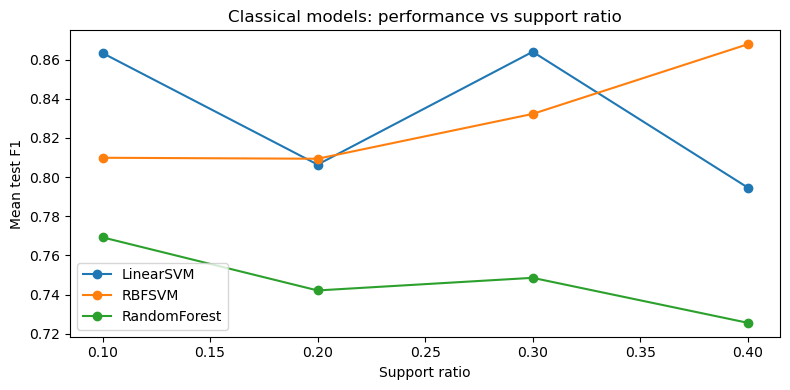

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
for model in best_by_support["model"].unique():
    sub = best_by_support[best_by_support["model"] == model]
    plt.plot(sub["support_ratio"], sub["mean_test_f1"], marker="o", label=model)

plt.xlabel("Support ratio")
plt.ylabel("Mean test F1")
plt.title("Classical models: performance vs support ratio")
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
comparison_rows = []

# 1) Best classical run overall
idx_max = classic_results["test_f1"].idxmax()
best_classic = classic_results.loc[idx_max]
comparison_rows.append({
    "model": f"Best classical ({best_classic['model']})",
    "test_f1": best_classic["test_f1"],
    "seed": best_classic["seed"],
    "support_ratio": best_classic["support_ratio"],
})

# 2) GNNs (values pulled from your GNN evaluation cells)
#comparison_rows.append({"model": "GCN", "test_f1": gcn_test_f1})
# comparison_rows.append({"model": "GraphSAGE", "test_f1": sage_test_f1})

comparison_df = pd.DataFrame(comparison_rows)
display(comparison_df)


,model,test_f1,seed,support_ratio
0,Best classical (LinearSVM),1.0,1,0.1


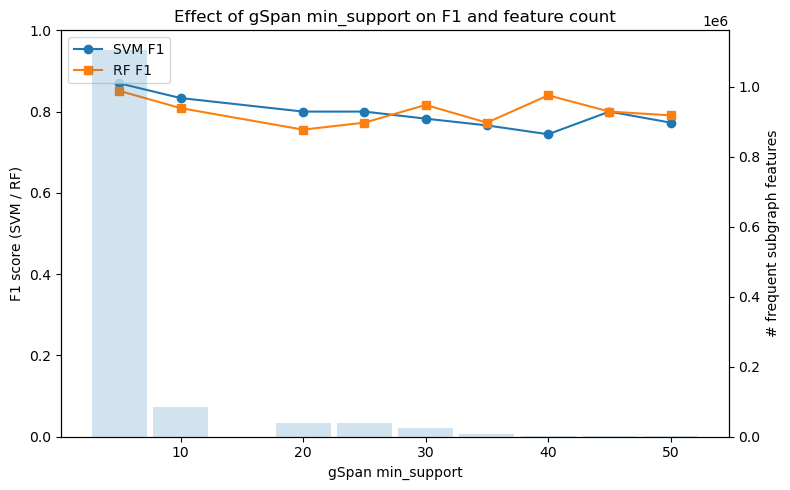

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# FIGURE 2: Min-support vs F1 and #features
# -------------------------------
# WHAT:
#   Visualize the tradeoff:
#     - x-axis: gSpan min_support
#     - left y-axis: SVM / RF F1 score
#     - right y-axis: number of features (subgraphs)
#
# WHY:
#   Shows how support threshold controls feature dimensionality
#   and downstream classifier performance.


def plot_min_support_ablation(ablation_df):
    supports = ablation_df["support"].values
    svm_f1 = ablation_df["svm_f1"].values
    rf_f1 = ablation_df["rf_f1"].values
    n_features = ablation_df["n_features"].values

    fig, ax1 = plt.subplots(figsize=(8, 5))

    # Left axis: F1 scores
    ax1.set_xlabel("gSpan min_support")
    ax1.set_ylabel("F1 score (SVM / RF)")
    ax1.plot(supports, svm_f1, marker="o", label="SVM F1")
    ax1.plot(supports, rf_f1, marker="s", label="RF F1")
    ax1.set_ylim(0, 1.0)
    ax1.legend(loc="upper left")

    # Right axis: number of features
    ax2 = ax1.twinx()
    ax2.set_ylabel("# frequent subgraph features")
    ax2.bar(
        supports,
        n_features,
        alpha=0.2,
        width=(supports.max() - supports.min()) / (len(supports) + 1),
        label="#features",
    )

    plt.title("Effect of gSpan min_support on F1 and feature count")
    fig.tight_layout()
    plt.show()


# Example call:
plot_min_support_ablation(ablation_df)


In [42]:
# ============================================================
# Q-2: GNNs on MUTAG – GCN + GraphSAGE
# ============================================================

# WHAT:
#   We will train two graph neural network models for MUTAG:
#     1) A GCN-based graph classifier
#     2) A GraphSAGE-based graph classifier
#
# WHY:
#   This satisfies Q-2 of your project:
#   "Train at least two GNN architectures (e.g., GCN, GraphSAGE) for
#   graph classification and analyze their performance." 
#
# HOW:
#   Use PyTorch Geometric (PyG) to:
#     - Load MUTAG graphs
#     - Build GNN models
#     - Train with early stopping
#     - Evaluate accuracy & F1 on a held-out test set

import os
import copy
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import (
    GCNConv,       # GCN layer
    SAGEConv,      # GraphSAGE layer
    global_mean_pool  # graph-level pooling (aggregates node embeddings)
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# ------------------------------
# Choose device (CPU or GPU)
# ------------------------------
# WHAT: Use GPU if available, otherwise CPU.
# WHY: GNN training can be accelerated by GPU, but should still run on CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ------------------------------
# Set random seeds for reproducibility
# ------------------------------
# WHAT: Fix seeds for numpy and torch.
# WHY: Makes runs more repeatable (same splits, similar metrics).
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if device.type == "cuda":
    torch.cuda.manual_seed_all(SEED)


Using device: cpu


In [43]:
# ============================================================
# 1) Load the MUTAG dataset
# ============================================================

# WHAT:
#   Load the MUTAG graph classification dataset from PyG.
#
# WHY:
#   MUTAG is the required dataset in your project – 188 small graphs
#   (chemical compounds) with binary labels (mutagenic / non-mutagenic).
#
# HOW:
#   TUDataset(root="data", name="MUTAG") automatically downloads
#   and loads the dataset if not already present.

dataset = TUDataset(root="data", name="MUTAG")

print("Number of graphs in MUTAG:", len(dataset))
print("Number of node features  :", dataset.num_features)
print("Number of classes        :", dataset.num_classes)

# Inspect one example graph to understand structure
data0 = dataset[0]
print("\nExample graph 0:")
print("  num_nodes:", data0.num_nodes)
print("  num_edges:", data0.num_edges)
print("  x shape  :", None if data0.x is None else data0.x.shape)
print("  y label  :", data0.y.item())


Number of graphs in MUTAG: 188
Number of node features  : 7
Number of classes        : 2

Example graph 0:
  num_nodes: 17
  num_edges: 38
  x shape  : torch.Size([17, 7])
  y label  : 1


In [44]:
import torch
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import numpy as np

def evaluate_gnn(model, loader, device):
    """
    WHAT:
        Evaluate a graph classification GNN on a DataLoader.

    HOW:
        - Puts model in eval mode.
        - Iterates over all batches, collects predictions and labels.
        - Computes:
            * accuracy
            * F1-score (binary)
            * ROC-AUC (if possible)

    RETURNS:
        metrics_dict, y_true, y_prob
        where:
          - metrics_dict has 'accuracy', 'f1', 'roc_auc'
          - y_true is a 1D numpy array of labels
          - y_prob is a 1D numpy array of predicted prob for class 1
    """
    model.eval()
    all_logits = []
    all_labels = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)  # [batch_size, num_classes]
            all_logits.append(out.cpu())
            all_labels.append(data.y.cpu())

    logits = torch.cat(all_logits, dim=0)      # [N_graphs, num_classes]
    labels = torch.cat(all_labels, dim=0)      # [N_graphs]

    # Convert to numpy
    y_true = labels.numpy()
    # For binary classification, turn logits into probabilities for class 1
    probs = torch.softmax(logits, dim=1)[:, 1].numpy()
    y_pred = (probs >= 0.5).astype(int)

    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)

    # ROC-AUC can fail if only one class is present, so be careful
    try:
        roc = roc_auc_score(y_true, probs)
    except ValueError:
        roc = np.nan

    metrics = {
        "accuracy": acc,
        "f1": f1,
        "roc_auc": roc,
    }
    return metrics, y_true, probs


In [45]:
# ============================================================
# 2) Train / validation / test split
# ============================================================

# WHAT:
#   Split the 188 graphs into:
#     - ~60% training
#     - ~20% validation
#     - ~20% test
#
# WHY:
#   - Train set: update model weights.
#   - Validation set: tune hyperparameters / early stopping.
#   - Test set: final unbiased performance estimate.
#
# HOW:
#   Use sklearn.train_test_split with stratification on labels
#   so class balance is similar across splits.

num_graphs = len(dataset)

# All graph indices
all_indices = np.arange(num_graphs)

# Graph labels as a NumPy array for stratification
all_labels = np.array([graph.y.item() for graph in dataset])

# First split: train (60%) vs temp (40%)
train_idx, temp_idx, y_train, y_temp = train_test_split(
    all_indices,
    all_labels,
    test_size=0.4,       # 40% goes to temp
    stratify=all_labels,
    random_state=SEED
)

# Second split: validation (20%) vs test (20%) from temp
val_idx, test_idx, y_val, y_test = train_test_split(
    temp_idx,
    y_temp,
    test_size=0.5,       # split temp 50/50 -> 20% val, 20% test
    stratify=y_temp,
    random_state=SEED
)

print("Train graphs:", len(train_idx))
print("Val graphs:  ", len(val_idx))
print("Test graphs: ", len(test_idx))

# Build subset datasets by indexing into MUTAG
# HOW: dataset[...] returns Data objects; wrapping them in a list
#      is enough for PyG's DataLoader.
train_dataset = [dataset[i] for i in train_idx]
val_dataset   = [dataset[i] for i in val_idx]
test_dataset  = [dataset[i] for i in test_idx]

# Wrap them in DataLoader for batching
# WHY: DataLoader handles:
#   - batching multiple graphs
#   - shuffling during training
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)


Train graphs: 112
Val graphs:   38
Test graphs:  38


In [46]:
# ============================================================
# 3) Training & evaluation helpers
# ============================================================

# WHAT:
#   - train_one_epoch: trains the model for a single epoch.
#   - eval_model: evaluates the model (no parameter updates).
#
# WHY:
#   Avoid duplicating logic for GCN and GraphSAGE; ensures
#   a fair comparison (same training procedure).
#
# HOW:
#   - Loop over batches from DataLoader
#   - Move batch to device (CPU/GPU)
#   - Forward pass → logits
#   - Compute cross-entropy loss
#   - Backprop + optimizer.step (train only)
#   - Track loss, accuracy, F1 across the whole split

def train_one_epoch(model, loader, optimizer, criterion, device):
    """
    Train the model for ONE epoch on the given DataLoader.
    """
    model.train()  # enable dropout, batchnorm, etc.

    total_loss = 0.0
    all_preds = []
    all_labels = []

    for batch in loader:
        # Move batch (graphs) to device
        batch = batch.to(device)

        # Zero out gradients from previous iteration
        optimizer.zero_grad()

        # Forward pass:
        #   model outputs class scores (logits) for each graph in the batch
        logits = model(batch)   # shape: [batch_size, num_classes]

        # Ground-truth graph labels
        y = batch.y.view(-1)    # ensure shape: [batch_size]

        # Compute loss for this batch
        loss = criterion(logits, y)

        # Backpropagate to compute gradients
        loss.backward()

        # Update model parameters using optimizer
        optimizer.step()

        # Accumulate total loss (weighted by batch size)
        total_loss += loss.item() * batch.num_graphs

        # Convert logits to predicted class indices
        preds = logits.argmax(dim=1).detach().cpu().numpy()
        labels = y.detach().cpu().numpy()

        all_preds.append(preds)
        all_labels.append(labels)

    # Concatenate predictions/labels from all batches
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Compute average loss & metrics across the entire training set
    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)  # binary F1 by default

    return avg_loss, acc, f1


@torch.no_grad()
def eval_model(model, loader, criterion, device):
    """
    Evaluate the model on validation or test set (no gradient updates).
    """
    model.eval()  # disable dropout, etc.

    total_loss = 0.0
    all_preds = []
    all_labels = []

    for batch in loader:
        batch = batch.to(device)

        logits = model(batch)
        y = batch.y.view(-1)

        loss = criterion(logits, y)
        total_loss += loss.item() * batch.num_graphs

        preds = logits.argmax(dim=1).cpu().numpy()
        labels = y.cpu().numpy()

        all_preds.append(preds)
        all_labels.append(labels)

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    return avg_loss, acc, f1


In [47]:
def train_with_early_stopping(
    model,
    train_loader,
    val_loader,
    device,
    max_epochs=200,
    lr=0.01,
    weight_decay=5e-4,
    patience=20,
):
    """
    Train a GNN model with early stopping based on validation accuracy.

    WHAT:
      - Train the model for up to max_epochs.
      - After each epoch, evaluate on validation set.
      - If validation accuracy does not improve for 'patience' epochs
        in a row, stop training and revert to the best weights.

    WHY:
      Prevent overfitting and save time; we only keep the model
      that performed best on the validation set.

    RETURNS:
      - best_model: model with best validation accuracy
      - history: list of per-epoch metrics for plotting/report
    """
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0.0
    best_state_dict = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0

    history = []

    for epoch in range(1, max_epochs + 1):
        # --- Training on the training set ---
        train_loss, train_acc, train_f1 = train_one_epoch(
            model, train_loader, optimizer, criterion, device
        )

        # --- Evaluation on the validation set ---
        val_loss, val_acc, val_f1 = eval_model(
            model, val_loader, criterion, device
        )

        # Save metrics for later analysis / plotting
        history.append(
            {
                "epoch": epoch,
                "train_loss": train_loss,
                "train_acc": train_acc,
                "train_f1": train_f1,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "val_f1": val_f1,
            }
        )

        print(
            f"Epoch {epoch:03d} | "
            f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f} | "
            f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}"
        )

        # Check if validation accuracy improved
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state_dict = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Stop if no improvement for 'patience' epochs
        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered after {epoch} epochs.")
            break

    # Restore the best model weights (highest validation accuracy)
    model.load_state_dict(best_state_dict)
    return model, history


In [48]:
# ============================================================
# 4) GCN-based graph classifier
# ============================================================

# WHAT:
#   A simple 2-layer GCN for graph classification:
#     - Two GCNConv layers to update node embeddings
#     - Mean pooling over nodes to get graph-level embedding
#     - Linear layer to predict class logits per graph
#
# WHY:
#   GCN is a canonical GNN architecture and a strong baseline for
#   many graph classification tasks.

class GCNGraphClassifier(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()

        # First GCN layer:
        #   Input: node features of dimension in_channels
        #   Output: hidden node embeddings
        self.conv1 = GCNConv(in_channels, hidden_channels)

        # Second GCN layer:
        #   Input: hidden embeddings
        #   Output: hidden embeddings (same dimension)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

        # Final linear layer to map graph embedding -> class logits
        self.lin = nn.Linear(hidden_channels, num_classes)

        # Dropout rate for regularization (to reduce overfitting)
        self.dropout = dropout

    def forward(self, data):
        # data is a PyG Batch object with:
        #   data.x          : node features [num_nodes_total, in_channels]
        #   data.edge_index : edges [2, num_edges_total]
        #   data.batch      : graph IDs for each node [num_nodes_total]
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # 1st GCN layer followed by ReLU non-linearity
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        # Apply dropout to node embeddings during training
        x = F.dropout(x, p=self.dropout, training=self.training)

        # 2nd GCN layer + ReLU
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Graph-level pooling:
        #   Aggregate node embeddings into a single vector per graph
        #   Here we use mean pooling (can also try sum or max).
        x = global_mean_pool(x, batch)

        # Final linear layer to obtain logits for each graph
        out = self.lin(x)
        return out


In [49]:
# ============================================================
# 5) GraphSAGE-based graph classifier
# ============================================================

# WHAT:
#   A 2-layer GraphSAGE model for graph classification:
#     - Two SAGEConv layers to update node embeddings
#     - Mean pooling for graph-level embedding
#     - Linear layer for class logits
#
# WHY:
#   GraphSAGE uses neighborhood sampling and aggregation, and is
#   another standard architecture in graph ML. Comparing GraphSAGE
#   and GCN fits the "two GNN architectures" requirement.

class GraphSAGEGraphClassifier(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()

        # First GraphSAGE layer
        self.conv1 = SAGEConv(in_channels, hidden_channels)

        # Second GraphSAGE layer
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)

        # Linear classifier from graph embedding to class logits
        self.lin = nn.Linear(hidden_channels, num_classes)

        self.dropout = dropout

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # 1st SAGE layer + ReLU
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        x = F.dropout(x, p=self.dropout, training=self.training)

        # 2nd SAGE layer + ReLU
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Graph-level mean pooling
        x = global_mean_pool(x, batch)

        # Linear classification layer
        out = self.lin(x)
        return out


In [50]:
import torch.nn as nn
from types import SimpleNamespace

class GraphClassifierWrapper(nn.Module):
    """
    WHAT:
        Small adapter that lets PyG's Explainer call your model with
        (x, edge_index, batch) instead of a single `data` object.

    WHY:
        Your GCN/GraphSAGE are written as forward(self, data), but
        Explainer expects forward(self, x, edge_index, batch).
        This wrapper glues the two worlds together.

    HOW:
        - Receives x, edge_index, batch from Explainer
        - Builds a lightweight object with attributes .x, .edge_index, .batch
        - Calls the original model on that object
    """
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model

    def forward(self, x, edge_index, batch):
        # Create a simple "data-like" object with required attributes
        data = SimpleNamespace(x=x, edge_index=edge_index, batch=batch)
        return self.base_model(data)


In [51]:
# ============================================================
# 6) Train & evaluate GCN and GraphSAGE
# ============================================================

num_node_features = dataset.num_features
num_classes = dataset.num_classes

# --------------------- Train GCN ---------------------
print("\n==================== GCN MODEL ====================")

gcn_model = GCNGraphClassifier(
    in_channels=num_node_features,
    hidden_channels=64,   # you can ablate 32 vs 64 vs 128 later
    num_classes=num_classes,
    dropout=0.5
)

gcn_model, gcn_history = train_with_early_stopping(
    model=gcn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    max_epochs=200,
    lr=0.01,
    weight_decay=5e-4,
    patience=20
)

# Evaluate on the test set
criterion = nn.CrossEntropyLoss()
gcn_test_loss, gcn_test_acc, gcn_test_f1 = eval_model(
    gcn_model, test_loader, criterion, device
)

print("\nGCN Test Results:")
print(f"  Loss: {gcn_test_loss:.4f}")
print(f"  Acc:  {gcn_test_acc:.4f}")
print(f"  F1:   {gcn_test_f1:.4f}")

gcn_metrics = {
    "accuracy": float(gcn_test_acc),
    "f1":       float(gcn_test_f1),
    # If you don't compute ROC-AUC for GNNs, just mark as NaN.
    # The plotting code will ignore/handle NaNs gracefully.
    "roc_auc":  np.nan,
}


# ----------------- Train GraphSAGE -------------------
print("\n================= GraphSAGE MODEL =================")

sage_model = GraphSAGEGraphClassifier(
    in_channels=num_node_features,
    hidden_channels=64,
    num_classes=num_classes,
    dropout=0.5
)

sage_model, sage_history = train_with_early_stopping(
    model=sage_model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    max_epochs=200,
    lr=0.01,
    weight_decay=5e-4,
    patience=20
)

sage_test_loss, sage_test_acc, sage_test_f1 = eval_model(
    sage_model, test_loader, criterion, device
)

print("\nGraphSAGE Test Results:")
print(f"  Loss: {sage_test_loss:.4f}")
print(f"  Acc:  {sage_test_acc:.4f}")
print(f"  F1:   {sage_test_f1:.4f}")

sage_metrics = {
    "accuracy": float(sage_test_acc),
    "f1":       float(sage_test_f1),
    "roc_auc":  np.nan,
}



==================== GCN MODEL ====================
Epoch 001 | Train Loss: 0.6506, Acc: 0.6250, F1: 0.7308 | Val Loss: 0.6131, Acc: 0.6842, F1: 0.8125
Epoch 002 | Train Loss: 0.6293, Acc: 0.6607, F1: 0.7957 | Val Loss: 0.6042, Acc: 0.6842, F1: 0.8125
Epoch 003 | Train Loss: 0.6172, Acc: 0.6607, F1: 0.7957 | Val Loss: 0.6017, Acc: 0.6842, F1: 0.8125
Epoch 004 | Train Loss: 0.6161, Acc: 0.6607, F1: 0.7957 | Val Loss: 0.5824, Acc: 0.6842, F1: 0.8125
Epoch 005 | Train Loss: 0.6022, Acc: 0.6607, F1: 0.7957 | Val Loss: 0.5743, Acc: 0.6842, F1: 0.8125
Epoch 006 | Train Loss: 0.5921, Acc: 0.6607, F1: 0.7957 | Val Loss: 0.5747, Acc: 0.6842, F1: 0.8125
Epoch 007 | Train Loss: 0.5791, Acc: 0.6607, F1: 0.7957 | Val Loss: 0.5574, Acc: 0.6842, F1: 0.8125
Epoch 008 | Train Loss: 0.5666, Acc: 0.6607, F1: 0.7957 | Val Loss: 0.5502, Acc: 0.7368, F1: 0.8387
Epoch 009 | Train Loss: 0.5563, Acc: 0.7232, F1: 0.8268 | Val Loss: 0.5430, Acc: 0.7368, F1: 0.8387
Epoch 010 | Train Loss: 0.5436, Acc: 0.7143, F1

In [52]:
import time
import pandas as pd

# ============================================================
# A.1) Helper: run a single GNN experiment (GCN or GraphSAGE)
# ============================================================

def run_gnn_experiment(
    model_type,
    hidden_channels=64,
    dropout=0.5,
    max_epochs=200,
    lr=0.01,
    weight_decay=5e-4,
    patience=20,
):
    """
    WHAT:
        Train *one* GNN configuration and evaluate on the test set.

    WHY:
        Ablation = systematically testing different configurations.
        This function encapsulates:
            - model construction
            - training w/ early stopping
            - final test evaluation
            - runtime measurement

    INPUT:
        model_type: "gcn" or "sage"
        hidden_channels: size of hidden layer
        dropout: dropout probability
        max_epochs, lr, weight_decay, patience: training hyperparameters

    RETURNS:
        dict with:
            - model_type
            - hidden_channels
            - dropout
            - best_val_acc (from training)
            - test_loss, test_acc, test_f1
            - train_time_seconds
    """

    num_node_features = dataset.num_features
    num_classes = dataset.num_classes

    # ----- 1) Instantiate the model based on type -----
    if model_type.lower() == "gcn":
        model = GCNGraphClassifier(
            in_channels=num_node_features,
            hidden_channels=hidden_channels,
            num_classes=num_classes,
            dropout=dropout,
        )
    elif model_type.lower() == "sage":
        model = GraphSAGEGraphClassifier(
            in_channels=num_node_features,
            hidden_channels=hidden_channels,
            num_classes=num_classes,
            dropout=dropout,
        )
    else:
        raise ValueError("model_type must be 'gcn' or 'sage'.")

    # ----- 2) Train with early stopping -----
    start_time = time.time()

    model, history = train_with_early_stopping(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        max_epochs=max_epochs,
        lr=lr,
        weight_decay=weight_decay,
        patience=patience,
    )

    train_time = time.time() - start_time

    # Best validation accuracy from history
    best_val_acc = max(h["val_acc"] for h in history)

    # ----- 3) Final test evaluation -----
    criterion = nn.CrossEntropyLoss()
    test_loss, test_acc, test_f1 = eval_model(model, test_loader, criterion, device)

    # Wrap everything in a dict for easy tabulation
    result = {
        "model_type": model_type,
        "hidden_channels": hidden_channels,
        "dropout": dropout,
        "best_val_acc": best_val_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "test_f1": test_f1,
        "train_time_sec": train_time,
    }

    return result, model, history


In [53]:
# ============================================================
# A.2) Ablation over multiple GNN configurations
# ============================================================

def ablate_gnn_models(
    model_types=("gcn", "sage"),
    hidden_list=(32, 64, 128, 256),
    dropout_list=(0.0, 0.1, 0.25, 0.5),
):
    """
    WHAT:
        Systematically explore different GNN configurations and
        record their performance and runtime.

    WHY:
        This is the ablation study: we vary architecture knobs
        (hidden size, dropout) and measure the effect on:
          - validation accuracy (model selection)
          - test accuracy / F1 (performance)
          - train time (efficiency)

    HOW:
        For each combination of:
            model_type ∈ model_types
            hidden_channels ∈ hidden_list
            dropout ∈ dropout_list
        run a full train+test experiment and store the results.
    """
    results = []

    for mtype in model_types:
        for hidden in hidden_list:
            for drop in dropout_list:
                print(f"\n=== Running {mtype.upper()} with hidden={hidden}, dropout={drop} ===")
                res, model, history = run_gnn_experiment(
                    model_type=mtype,
                    hidden_channels=hidden,
                    dropout=drop,
                )
                results.append(res)

    # Convert list of dicts to a pandas DataFrame for easy viewing
    return pd.DataFrame(results)


# Example usage (feel free to reduce if it trains too long):
ablation_results = ablate_gnn_models(
    model_types=("gcn", "sage"),
    hidden_list=(16, 32, 64, 128, 256),
    dropout_list=(0.0, 0.01, 0.05, 0.1, 0.25, 0.5),
)

print("\n=== GNN Ablation Results ===")
print(ablation_results)



=== Running GCN with hidden=16, dropout=0.0 ===
Epoch 001 | Train Loss: 0.6523, Acc: 0.6607, F1: 0.7957 | Val Loss: 0.6206, Acc: 0.6842, F1: 0.8125
Epoch 002 | Train Loss: 0.6294, Acc: 0.6607, F1: 0.7957 | Val Loss: 0.6058, Acc: 0.6842, F1: 0.8125
Epoch 003 | Train Loss: 0.6319, Acc: 0.6607, F1: 0.7957 | Val Loss: 0.6036, Acc: 0.6842, F1: 0.8125
Epoch 004 | Train Loss: 0.6188, Acc: 0.6607, F1: 0.7957 | Val Loss: 0.6025, Acc: 0.6842, F1: 0.8125
Epoch 005 | Train Loss: 0.6233, Acc: 0.6607, F1: 0.7957 | Val Loss: 0.6092, Acc: 0.6842, F1: 0.8125
Epoch 006 | Train Loss: 0.6204, Acc: 0.6607, F1: 0.7957 | Val Loss: 0.6067, Acc: 0.6842, F1: 0.8125
Epoch 007 | Train Loss: 0.6149, Acc: 0.6607, F1: 0.7957 | Val Loss: 0.5956, Acc: 0.6842, F1: 0.8125
Epoch 008 | Train Loss: 0.6061, Acc: 0.6607, F1: 0.7957 | Val Loss: 0.5879, Acc: 0.6842, F1: 0.8125
Epoch 009 | Train Loss: 0.6012, Acc: 0.6607, F1: 0.7957 | Val Loss: 0.5818, Acc: 0.6842, F1: 0.8125
Epoch 010 | Train Loss: 0.5932, Acc: 0.6607, F1: 0.

In [54]:
# ============================================================
# B.1) Helper: get class probabilities from a model for one graph
# ============================================================

def get_probs_for_graph(model, data, device):
    """
    WHAT:
        Run a trained graph classifier on a single Data object and
        return softmax probabilities.

    WHY:
        We need probabilities to compute fidelity metrics
        for explanations (before/after masking).

    HOW:
        - Put model in eval mode
        - Move 'data' to device
        - Run forward pass
        - Apply softmax to logits
    """
    model.eval()
    data = data.to(device)

    with torch.no_grad():
        logits = model(data)        # shape [1, num_classes] for one graph
        probs = F.softmax(logits, dim=-1)  # convert logits -> probabilities

    return probs.squeeze(0).cpu()   # shape [num_classes]


In [55]:
from torch_geometric.data import Data
from torch_geometric.explain import Explainer, GNNExplainer, ModelConfig
import time

def explain_graph_with_metrics(
    model,
    data,
    device,
    threshold=0.5,
    explainer_epochs=200,
):
    """
    WHAT:
        Use the *new* PyG Explainer + GNNExplainer API to produce an
        edge-level explanation for a single graph, then compute:
          - sparsity
          - fidelity+  (keep important edges)
          - fidelity-  (keep only unimportant edges)
          - explanation runtime

    HOW (high level):
        1. Wrap your trained model in `Explainer` with `GNNExplainer`.
        2. Call the explainer on (x, edge_index, batch) to get an
           Explanation object.
        3. Extract edge_mask and threshold it.
        4. Build:
            - subgraph_keep: only important edges
            - subgraph_comp: only unimportant edges
        5. Evaluate model probabilities on:
            - full graph
            - subgraph_keep
            - subgraph_comp
        6. Compute sparsity, fidelity+, fidelity-.

    NOTE:
        We assume your model returns *raw logits* (as in your GCN/GraphSAGE),
        so we use ModelConfig(return_type='raw').
    """
    model = model.to(device)
    model.eval()

    # We'll use the *wrapped* model for Explainer,
    # but the original model for probability calculations.
    wrapped_model = GraphClassifierWrapper(model).to(device)
    wrapped_model.eval()
    model = model.to(device)
    model.eval()

    # --------- 1) Build the Explainer wrapper ----------
    explainer = Explainer(
        model=wrapped_model,
        algorithm=GNNExplainer(epochs=explainer_epochs),
        explanation_type="model",      # explain the model's own prediction
        model_config=dict(
            mode="binary_classification",   # MUTAG is binary graph classification
            task_level="graph",             # graph-level prediction
            return_type="raw",              # model outputs raw logits
        ),
        node_mask_type="attributes",
        edge_mask_type="object",
    )

    # Single-graph tensors
    x = data.x.to(device)
    edge_index = data.edge_index.to(device)
    batch = torch.zeros(data.num_nodes, dtype=torch.long, device=device)

    # --------- 2) Run the explainer ----------
    start_time = time.time()
    explanation = explainer(x, edge_index, batch=batch)
    expl_time = time.time() - start_time

    node_feat_mask = explanation.node_mask
    edge_mask = explanation.edge_mask          # [num_edges]
    num_edges = edge_mask.size(0)

    # --------- 3) Threshold edge_mask to select important edges ----------
    important_mask = edge_mask > threshold
    num_important = int(important_mask.sum().item())

    # If nothing survives the threshold, keep the single most important edge
    if num_important == 0:
        top_idx = edge_mask.argmax().unsqueeze(0)
        important_mask = torch.zeros_like(edge_mask, dtype=torch.bool)
        important_mask[top_idx] = True
        num_important = 1

    sparsity = 1.0 - num_important / num_edges

    # --------- 4) Probabilities on full graph (use original model) ---------
    probs_full = get_probs_for_graph(model, data, device)
    pred_class = int(probs_full.argmax().item())
    p_full = float(probs_full[pred_class].item())

    # Helper to create a new Data object with a subset of edges
    def make_subgraph(data, edge_mask_bool):
        edge_index_sub = data.edge_index[:, edge_mask_bool.cpu()]
        return Data(
            x=data.x,
            edge_index=edge_index_sub,
            y=data.y,
        )

    # Subgraph with only important edges
    data_keep = make_subgraph(data, important_mask)
    # Complement: only unimportant edges
    comp_mask = ~important_mask
    data_comp = make_subgraph(data, comp_mask)

    # --------- 5) Probabilities on subgraphs (original model) ----------
    probs_keep = get_probs_for_graph(model, data_keep, device)
    probs_comp = get_probs_for_graph(model, data_comp, device)

    p_keep = float(probs_keep[pred_class].item())
    p_comp = float(probs_comp[pred_class].item())

    # --------- 6) Fidelity+ and Fidelity- ----------
    fidelity_plus  = p_keep / p_full if p_full > 0 else 0.0
    fidelity_minus = 1.0 - (p_comp / p_full) if p_full > 0 else 0.0

    metrics = {
        "pred_class": pred_class,
        "p_full": p_full,
        "p_keep": p_keep,
        "p_comp": p_comp,
        "sparsity": sparsity,
        "fidelity_plus": fidelity_plus,
        "fidelity_minus": fidelity_minus,
        "expl_time_sec": expl_time,
        "num_edges": int(num_edges),
        "num_important_edges": int(num_important),
    }

    return metrics, node_feat_mask, edge_mask



test_graph_indices_to_explain = [0, 1, 2, 3, 4]

gcn_expl_results = []
sage_expl_results = []

print("\n=== GCN GNNExplainer Results ===")
for idx in test_graph_indices_to_explain:
    data_ex = test_dataset[idx]
    print(f"\nExplaining test graph index {idx} (GCN)...")
    metrics, node_mask, edge_mask = explain_graph_with_metrics(
        model=gcn_model,
        data=data_ex,
        device=device,
        threshold=0.5,
        explainer_epochs=200,
    )
    print(metrics)
    gcn_expl_results.append(metrics)

print("\n=== GraphSAGE GNNExplainer Results ===")
for idx in test_graph_indices_to_explain:
    data_ex = test_dataset[idx]
    print(f"\nExplaining test graph index {idx} (GraphSAGE)...")
    metrics, node_mask, edge_mask = explain_graph_with_metrics(
        model=sage_model,
        data=data_ex,
        device=device,
        threshold=0.5,
        explainer_epochs=200,
    )
    print(metrics)
    sage_expl_results.append(metrics)
    
    gcn_expl_df = pd.DataFrame(gcn_expl_results)
sage_expl_df = pd.DataFrame(sage_expl_results)

print(gcn_expl_df.head())
print(sage_expl_df.head())


=== GCN GNNExplainer Results ===

Explaining test graph index 0 (GCN)...
{'pred_class': 1, 'p_full': 0.6681492328643799, 'p_keep': 0.7163232564926147, 'p_comp': 0.6992250084877014, 'sparsity': 0.6818181818181819, 'fidelity_plus': 1.0721006943639089, 'fidelity_minus': -0.046510231688957404, 'expl_time_sec': 0.5613102912902832, 'num_edges': 44, 'num_important_edges': 14}

Explaining test graph index 1 (GCN)...
{'pred_class': 1, 'p_full': 0.7891699075698853, 'p_keep': 0.8325939774513245, 'p_comp': 0.7976567149162292, 'sparsity': 0.631578947368421, 'fidelity_plus': 1.0550249945732932, 'fidelity_minus': -0.010754093972586531, 'expl_time_sec': 0.4786190986633301, 'num_edges': 38, 'num_important_edges': 14}

Explaining test graph index 2 (GCN)...
{'pred_class': 1, 'p_full': 0.7318605780601501, 'p_keep': 0.7767099738121033, 'p_comp': 0.7791630625724792, 'sparsity': 0.6818181818181819, 'fidelity_plus': 1.0612813384085118, 'fidelity_minus': -0.06463319097977349, 'expl_time_sec': 0.4782023429870

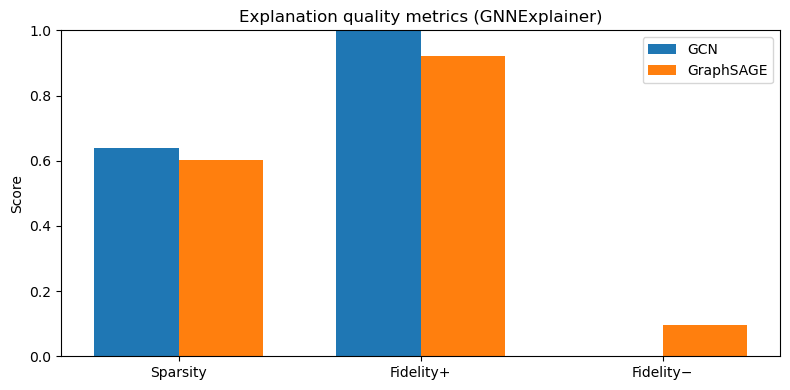

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# FIGURE 5: Explanation metrics
# -------------------------------
# WHAT:
#   Compare average:
#     - sparsity
#     - fidelity_plus
#     - fidelity_minus
#   for GCN vs GraphSAGE explanations.
#
# WHY:
#   Captures the compactness and faithfulness of explanations
#   and lets you compare GNNs in the Q-4 discussion.


def plot_explanation_metrics(gcn_expl_df, sage_expl_df):
    # Compute mean metrics for each model
    metrics = ["sparsity", "fidelity_plus", "fidelity_minus"]

    gcn_means = gcn_expl_df[metrics].mean()
    sage_means = sage_expl_df[metrics].mean()

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 4))

    ax.bar(x - width / 2, gcn_means[metrics], width, label="GCN")
    ax.bar(x + width / 2, sage_means[metrics], width, label="GraphSAGE")

    ax.set_xticks(x)
    ax.set_xticklabels(["Sparsity", "Fidelity+", "Fidelity−"])
    ax.set_ylim(0, 1.0)
    ax.set_ylabel("Score")
    ax.set_title("Explanation quality metrics (GNNExplainer)")
    ax.legend()

    plt.tight_layout()
    plt.show()


# Example call:
plot_explanation_metrics(gcn_expl_df, sage_expl_df)


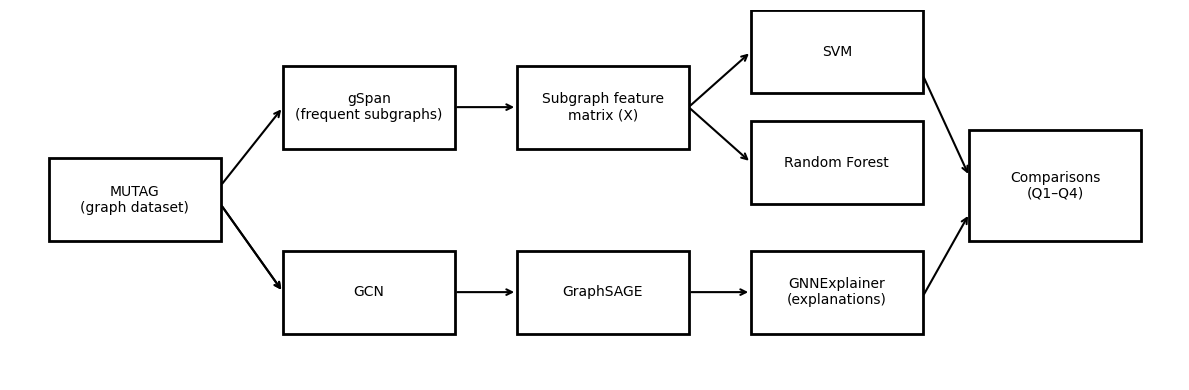

In [33]:
import matplotlib.pyplot as plt

# -------------------------------
# FIGURE 1: Pipeline diagram
# -------------------------------
# WHAT:
#   Simple left-to-right diagram that shows:
#     MUTAG → (Branch A) gSpan + classic ML
#           → (Branch B) GNNs + explanations
#
# HOW:
#   Use Matplotlib shapes (rectangles + arrows) so you can
#   generate it directly in Python and export as PNG / PDF.


def plot_pipeline_diagram():
    # Create a wide horizontal figure
    fig, ax = plt.subplots(figsize=(12, 4))
    
    # Make sure the background is white (useful if you're in dark mode)
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")
    
    # Turn off axes, we just want shapes
    ax.axis("off")

    # ---------------------------------------
    # 1) Helper to draw labeled boxes
    # ---------------------------------------
    def draw_box(x, y, text, width=2.2, height=0.9, fontsize=10):
        """
        Draw a rectangle with a centered text label.

        x, y = lower-left corner of the box
        width, height = box size
        text = label to show inside
        """
        rect = plt.Rectangle(
            (x, y),
            width,
            height,
            fill=False,            # no fill, just outline
            linewidth=2,
            edgecolor="black"      # EXPLICIT edge color so it always shows
        )
        ax.add_patch(rect)
        ax.text(
            x + width / 2,
            y + height / 2,
            text,
            ha="center",
            va="center",
            fontsize=fontsize
        )

    # ---------------------------------------
    # 2) Draw the boxes (pipeline stages)
    # ---------------------------------------

    # Main data source box
    draw_box(0, 1.5, "MUTAG\n(graph dataset)")

    # Branch A: classic ML
    draw_box(3, 2.5, "gSpan\n(frequent subgraphs)")
    draw_box(6, 2.5, "Subgraph feature\nmatrix (X)")
    draw_box(9, 3.1, "SVM")
    draw_box(9, 1.9, "Random Forest")

    # Branch B: GNNs
    draw_box(3, 0.5, "GCN")
    draw_box(6, 0.5, "GraphSAGE")
    draw_box(9, 0.5, "GNNExplainer\n(explanations)")

    # Final comparison box
    draw_box(11.8, 1.5, "Comparisons\n(Q1–Q4)", width=2.2, height=1.2)

    # ---------------------------------------
    # 3) Draw arrows (explicit color)
    # ---------------------------------------
    arrow_style = dict(arrowstyle="->", linewidth=1.5, color="black")

    # Arrows from MUTAG to both branches
    ax.annotate("", xy=(3, 2.95), xytext=(2.2, 2.1), arrowprops=arrow_style)
    ax.annotate("", xy=(3, 0.95), xytext=(2.2, 1.9), arrowprops=arrow_style)

    # Branch A arrows: gSpan → X → SVM/RF
    ax.annotate("", xy=(6, 2.95), xytext=(5.2, 2.95), arrowprops=arrow_style)
    ax.annotate("", xy=(9, 3.55), xytext=(8.2, 2.95), arrowprops=arrow_style)
    ax.annotate("", xy=(9, 2.35), xytext=(8.2, 2.95), arrowprops=arrow_style)

    # Branch B arrows: MUTAG → GCN → GraphSAGE → GNNExplainer
    ax.annotate("", xy=(3, 0.95), xytext=(2.2, 1.9), arrowprops=arrow_style)
    ax.annotate("", xy=(6, 0.95), xytext=(5.2, 0.95), arrowprops=arrow_style)
    ax.annotate("", xy=(9, 0.95), xytext=(8.2, 0.95), arrowprops=arrow_style)

    # Arrows into final comparison box
    ax.annotate("", xy=(11.8, 2.2), xytext=(11.2, 3.3), arrowprops=arrow_style)
    ax.annotate("", xy=(11.8, 1.8), xytext=(11.2, 0.9), arrowprops=arrow_style)

    # ---------------------------------------
    # 4) Make sure everything is in view
    # ---------------------------------------
    # Explicitly set limits so boxes & arrows aren't cropped
    ax.set_xlim(-0.5, 14.5)
    ax.set_ylim(0, 4)

    plt.tight_layout()
    plt.show()


# Call the function to create the figure
plot_pipeline_diagram()


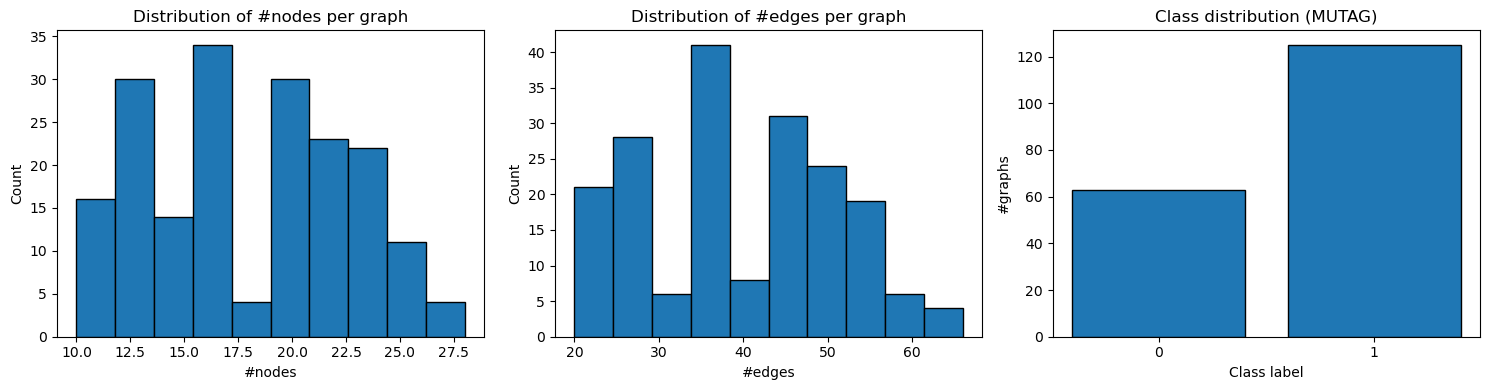

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# ---------------------------------------------------------
# FIGURE 1: MUTAG dataset overview
#   - Histogram of #nodes per graph
#   - Histogram of #edges per graph
#   - Bar chart of class balance
# ---------------------------------------------------------
# ASSUMPTION:
#   You already have MUTAG loaded as:
#       dataset = TUDataset(root="data", name="MUTAG")
#   If not, uncomment and run the lines below:
#
# from torch_geometric.datasets import TUDataset
# dataset = TUDataset(root="data", name="MUTAG")

# ----- 1) Collect simple per-graph stats -----
num_nodes = [data.num_nodes for data in dataset]     # number of nodes in each graph
num_edges = [data.num_edges for data in dataset]     # number of edges in each graph
labels    = [int(data.y.item()) for data in dataset] # graph labels: 0/1 for MUTAG

label_counts = Counter(labels)  # how many graphs in each class

# ----- 2) Create the figure with 3 subplots -----
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# (a) Histogram of #nodes per graph
axes[0].hist(num_nodes, bins=10, edgecolor="black")
axes[0].set_title("Distribution of #nodes per graph")
axes[0].set_xlabel("#nodes")
axes[0].set_ylabel("Count")

# (b) Histogram of #edges per graph
axes[1].hist(num_edges, bins=10, edgecolor="black")
axes[1].set_title("Distribution of #edges per graph")
axes[1].set_xlabel("#edges")
axes[1].set_ylabel("Count")

# (c) Class balance bar chart
classes = sorted(label_counts.keys())
counts  = [label_counts[c] for c in classes]

axes[2].bar([str(c) for c in classes], counts, edgecolor="black")
axes[2].set_title("Class distribution (MUTAG)")
axes[2].set_xlabel("Class label")
axes[2].set_ylabel("#graphs")

plt.tight_layout()
plt.show()


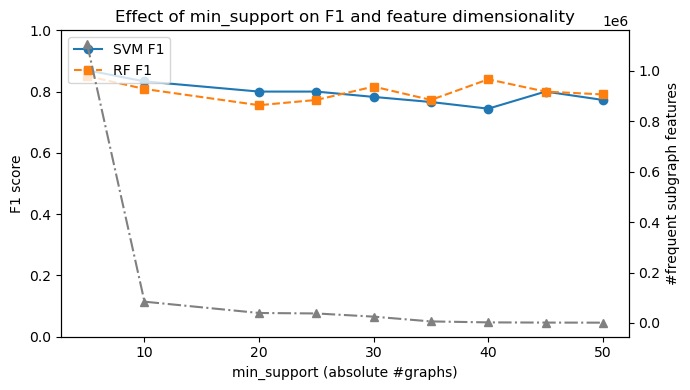

In [35]:
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# FIGURE 2: Classic ML ablation over min_support
#   - Left y-axis: F1 score vs min_support (SVM + RF)
#   - Right y-axis: number of features vs min_support
# ---------------------------------------------------------
# ASSUMPTION:
#   You already have ablation_df from ablation_over_supports().
#   Inspect it with:
#       print(ablation_df.head())
#   to make sure the column names match.

def plot_classic_ablation(ablation_df):
    # Sort by support so the curves are monotone in x
    ablation_sorted = ablation_df.sort_values("support")

    x = ablation_sorted["support"]

    # Create figure with twin y-axis:
    #   ax1: F1 scores for SVM/RF
    #   ax2: number of features
    fig, ax1 = plt.subplots(figsize=(7, 4))

    # ----- 1) Plot F1 scores on left y-axis -----
    ax1.plot(x, ablation_sorted["svm_f1"],
             marker="o", linestyle="-", label="SVM F1")
    ax1.plot(x, ablation_sorted["rf_f1"],
             marker="s", linestyle="--", label="RF F1")

    ax1.set_xlabel("min_support (absolute #graphs)")
    ax1.set_ylabel("F1 score")
    ax1.set_ylim(0.0, 1.0)
    ax1.legend(loc="upper left")

    # ----- 2) Plot #features on right y-axis -----
    ax2 = ax1.twinx()
    ax2.plot(x, ablation_sorted["n_features"],
             marker="^", linestyle="-.", color="gray", label="#features")

    ax2.set_ylabel("#frequent subgraph features")
    # Optional: force integer ticks if you want
    # ax2.yaxis.get_major_locator().set_params(integer=True)

    # Title that explains the story in one line
    plt.title("Effect of min_support on F1 and feature dimensionality")

    fig.tight_layout()
    plt.show()

# Call it:
plot_classic_ablation(ablation_df)


In [41]:
gcn_expl_df

,pred_class,p_full,p_keep,p_comp,sparsity,fidelity_plus,fidelity_minus,expl_time_sec,num_edges,num_important_edges
0,1,0.668149,0.783835,0.640767,0.818182,1.173144,0.040983,0.483528,44,8
1,1,0.789170,0.840407,0.818576,0.631579,1.064925,-0.037261,0.442955,38,14
2,1,0.731861,0.779738,0.726270,0.636364,1.065419,0.007639,0.444009,22,8
3,1,0.519120,0.625918,0.575575,0.678571,1.205728,-0.108751,0.428097,28,9
4,1,0.565174,0.701922,0.646010,0.545455,1.241957,-0.143028,0.429755,22,10


           model   family  accuracy        f1   roc_auc
0            SVM  Classic  0.763158  0.800000  0.838462
1  Random Forest  Classic  0.710526  0.755556  0.853846
2            GCN      GNN  0.684211  0.806452       NaN
3      GraphSAGE      GNN  0.736842  0.807692       NaN


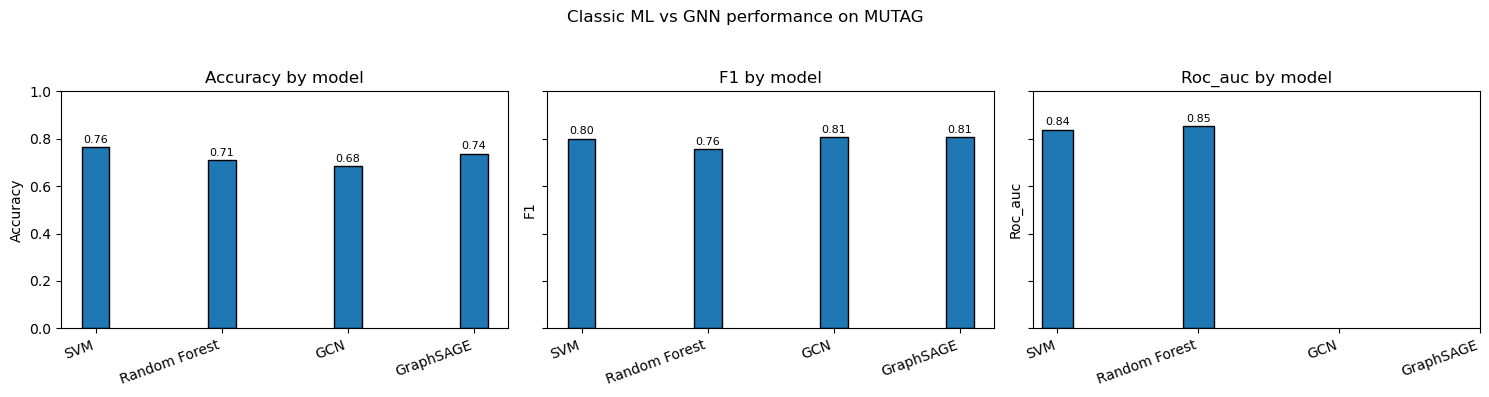

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------------------------------------
# FIGURE 3: Model comparison (Classic vs GNN)
#   Bar chart of Accuracy / F1 / ROC-AUC for:
#     - SVM
#     - RandomForest
#     - GCN
#     - GraphSAGE
# ---------------------------------------------------------
# ASSUMPTION:
#   You have metric dicts similar to:
#       svm_metrics  = {"accuracy": ..., "f1": ..., "roc_auc": ...}
#       rf_metrics   = {"accuracy": ..., "f1": ..., "roc_auc": ...}
#       gcn_metrics  = {"accuracy": ..., "f1": ..., "roc_auc": ...}
#       sage_metrics = {"accuracy": ..., "f1": ..., "roc_auc": ...}
#
#   If your GNN metrics are separate variables like:
#       gcn_test_acc, gcn_test_f1, ...
#   you can manually create the dicts below.

# ----- 1) Build a small summary table from metrics dicts -----
model_results = [
    {
        "model": "SVM",
        "family": "Classic",
        "accuracy": svm_metrics["accuracy"],
        "f1":       svm_metrics["f1"],
        "roc_auc":  svm_metrics.get("roc_auc", np.nan),
    },
    {
        "model": "Random Forest",
        "family": "Classic",
        "accuracy": rf_metrics["accuracy"],
        "f1":       rf_metrics["f1"],
        "roc_auc":  rf_metrics.get("roc_auc", np.nan),
    },
    {
        "model": "GCN",
        "family": "GNN",
        "accuracy": gcn_metrics["accuracy"],
        "f1":       gcn_metrics["f1"],
        "roc_auc":  gcn_metrics.get("roc_auc", np.nan),
    },
    {
        "model": "GraphSAGE",
        "family": "GNN",
        "accuracy": sage_metrics["accuracy"],
        "f1":       sage_metrics["f1"],
        "roc_auc":  sage_metrics.get("roc_auc", np.nan),
    },
]

perf_df = pd.DataFrame(model_results)

print(perf_df)

# ----- 2) Plot grouped bars for each metric -----
metrics = ["accuracy", "f1", "roc_auc"]
x = np.arange(len(perf_df))  # one bar group per model
width = 0.22                 # bar width

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for i, metric in enumerate(metrics):
    ax = axes[i]

    # Plot bars for this metric
    ax.bar(
        x,
        perf_df[metric],
        width,
        edgecolor="black",
    )

    ax.set_xticks(x)
    ax.set_xticklabels(perf_df["model"], rotation=20, ha="right")

    ax.set_ylim(0.0, 1.0)
    ax.set_ylabel(metric.capitalize())
    ax.set_title(f"{metric.capitalize()} by model")

    # Annotate bars with values
    for xi, val in zip(x, perf_df[metric]):
        if np.isnan(val):
            continue
        ax.text(xi, val + 0.01, f"{val:.2f}", ha="center", va="bottom", fontsize=8)

plt.suptitle("Classic ML vs GNN performance on MUTAG")
plt.tight_layout(rect=[0, 0.0, 1, 0.94])
plt.show()
